In [1]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
import time
import tensorflow as tf
import tqdm
import os
from scipy.integrate import solve_ivp
import findiff

In [2]:
import sys
sys.path.append('../..')

from systemidentification import twoConductanceEquations

In [3]:
# Configure tensorflow to use only the memory that it needs.
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
%matplotlib notebook

In [5]:
figure_path = figure_path = os.path.join('D:'+os.sep, "Kevrekidis' Lab", 'annForTrajectories', 'examples', 'HH Oscillator Project', 'figures', 'ODE 8 figures')
figure_saving = False

# Define some library functions

In [6]:
def flow_sim(X0,
             flow_time,
             healing_time,
             domain_size,
             domain
             ):
    """
    Return a an integration history object.
    
    Parameters
    ==========
    X0 : the initial condition of the integration
    flow_time : the integration time of the trajectory after healing_time
    healing_time : the healing integration time discarded before flow_time
    domain_size : the number of oscillators in the system
    domain : the applied currents of the oscillators
    
    """
    
    sim = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain)    
    f = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain).diff
    
    # Use Scipy's RK45 integrator for the flow generation.
    history = sim.integrate(
                            X0,
                            t_span=[0, healing_time + flow_time],
                            method='DOP853',
                            dense_output=True,
                            rtol=1e-9,
                            atol=1e-9
                           )
    
    return history
        
def data_generator(initial_conditions,
                   flow_time,
                   healing_time,
                   time_step,
                   domain_size,
                   domain,
                   samples_per_trajectory
                   ):
    """
    Return a set of preflow X data, postflow Y data, and a list of the integration restults for each pair.
    
    Parameters
    ==========
    initial_conditions : an iterator containing the initial conditions of the integration
    flow_time : the integration time of the trajectory after healing_time
    healing_time : the healing integration time discarded before flow_time
    time_step : the time step length used in the flow data generation collection
    domain_size : the number of oscillators in the system
    domain : the applied currents of the oscillators
    samples_per_trajectory : the number of samples collected from each intial condition (trajectory)
    
    """
    results = [flow_sim(X0, flow_time+time_step, healing_time, domain_size, domain) for X0 in tqdm.tqdm_notebook(initial_conditions)]

    X = np.empty((len(results) * samples_per_trajectory, domain_size, 2))
    Y = np.empty((len(results) * samples_per_trajectory, domain_size, 2))
    
    current_sample = 0
    for samp, result in tqdm.tqdm_notebook(enumerate(results)):
        # Pick the starting (X) times evenly over the interval [0, healing_time+flow_time].
        X_times = np.linspace(0, healing_time + flow_time, samples_per_trajectory)
        # Evaluate the end (Y) times at the starting_time + time_step
        Y_times = X_times + time_step
        # Evaluate the states at the selected times.
        states = result.sol(np.column_stack((X_times, Y_times)).ravel())
        for i in range(samples_per_trajectory):
            UV0, UV1 = states[:, 2*i], states[:, 2*i+1]
            X[current_sample, :, :] = UV0.reshape([2, domain_size]).T
            Y[current_sample, :, :] = UV1.reshape([2, domain_size]).T
            current_sample += 1

    return (X, Y, results)

In [7]:
class Normalizer():
    """
    A class for transforming data into mean deviation format.
    """
    
    def __init__(self, mean, std):
        """ Initialize the mean and standard deviation manually. """
        self.normalization_mean = mean
        self.normalization_std = std
    
    @classmethod
    def fromData(cls, data, axis):
        """ Initialize the mean and standard deviation by passing data. """
        normalization_mean = np.mean(data, axis=axis)
        normalization_std = np.std(data, axis=axis)
        return cls(mean=normalization_mean, std=normalization_std)
    
    def normalize(self, data):
        """ Perform the normalization process on the data using the means and stds defined in __init__. """
        return (data - self.normalization_mean) / self.normalization_std
    
    def unnormalize(self, data):
        """ Undo the normalization process on the data using the means and stds defined in __init__. """
        return (data * self.normalization_std) + self.normalization_mean

In [8]:
class Pbar(tf.keras.callbacks.Callback):

    def __init__(self, total):
        super().__init__()
        self.tqdm_notebook = tqdm.tqdm_notebook(total=total)

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm_notebook.update(1)

In [9]:
class FiniteDifference1D(tf.keras.layers.Layer):
    """
    Computes 1-dimensional, second order accurate, centered finite differences with convolutions
    for each input channel individually.
    """
    def __init__(self, maximum_derivative, dx, **tf_layer_kwargs):
        super().__init__(**tf_layer_kwargs)
        self.dx = tf.constant(dx, dtype=self.dtype, name='constant_dx')
        self.maximum_derivative = maximum_derivative
        self.kernel_size = len(findiff.coefficients(deriv=maximum_derivative, acc=2)['center']['coefficients'])
        
    def build(self, input_shape):
        fd_kernel = np.zeros((self.kernel_size, 1, self.maximum_derivative + 1))
        for i in range(self.maximum_derivative + 1):
            fd_coeffs = findiff.coefficients(deriv=i, acc=2)['center']['coefficients']
            fd_coeffs_length = len(fd_coeffs)
            pad_width = int((self.kernel_size - fd_coeffs_length) / 2)
            fd_kernel[:, 0, i] = np.pad(fd_coeffs, pad_width, mode='constant', constant_values=0) / dx ** i
    
        self.kernel = self.add_weight(name='fd_kernel',
                                      shape=fd_kernel.shape,
                                      initializer=tf.constant_initializer(value=fd_kernel),
                                      dtype=self.dtype,
                                      trainable=False
                                     )
    
    @tf.function
    def call(self, inputs):
        finite_differences = []
        for i in range(inputs.shape[-1]):
            finite_differences.append(tf.nn.conv1d(inputs[:, :, i:i+1], self.kernel, stride=1, padding='VALID'))
        return tf.concat(finite_differences, axis=-1)

In [10]:
class ODE_Euler(tf.keras.layers.Layer):
    """
    Calculate an Euler step.
    """
    def __init__(self, dt, **kwargs):
        super().__init__(**kwargs)
        self.dt = tf.constant(dt, dtype=self.dtype, name='flow_time')
            
    @tf.function
    def call(self, inputs):
        """
        Evaluates the Euler step from a list of two inputs (state_tensor, derivative_tensor).
        """
        states = inputs[0]
        derivative = inputs[1]
        return states + self.dt * derivative

In [11]:
class WeightedMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self, weights, scale, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights
        self.scale = scale
    
    @tf.function
    def call(self, y_true, y_pred):
        return self.scale * tf.math.reduce_mean(self.weights * tf.square(y_true - y_pred))

In [12]:
def pca_filter(data, pca, normalizer, number_of_retained_pca_coordinates):
    norm_data = normalizer.normalize(data)
    pca_data = pca.transform(norm_data)
    pca_data[:, number_of_retained_pca_coordinates:] = 0
    filtered_data = pca.inverse_transform(pca_data)
    return normalizer.unnormalize(filtered_data)

# Load the Initial Conditions

In [13]:
data = np.load(os.path.join(os.getcwd(), 'HH Data', 'Data Initialization', 'Initializations.npz'))

domain = data['domain']
dx = np.diff(domain)[-1]
adjacency_matrix = data['adjacency_matrix']
X0 = data['X0']
starting_points = data['starting_points'][::2, :, :]
starting_times = data['starting_times'][::2]

domain_size = domain.shape[0]
X0 = X0.reshape((2, domain_size)).T
sim = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain, A=adjacency_matrix)

# Compare a Combined PCA to Individual PCAs

<IPython.core.display.Javascript object>


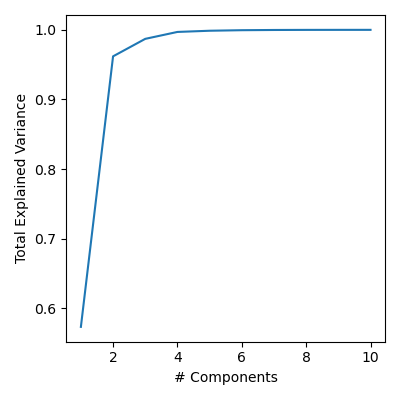

In [14]:
pca = PCA(svd_solver='full')

combined_data = np.transpose(starting_points, [0, 2, 1]).reshape((-1, 2 * domain_size))

normalization_mean = np.mean(combined_data, axis=0)
normalization_std = np.std(combined_data, axis=0)
normalizer = Normalizer(mean=normalization_mean, std=normalization_std)

pca.fit(normalizer.normalize(combined_data))

fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
ax.plot(np.arange(1, 11), np.cumsum(pca.explained_variance_ratio_[:10]));

ax.set_xlabel('# Components');
ax.set_ylabel('Total Explained Variance');
fig.tight_layout();

if figure_saving:
    fig.savefig(os.path.join(figure_path, 'POD_variance.png'), dpi=300)

<IPython.core.display.Javascript object>


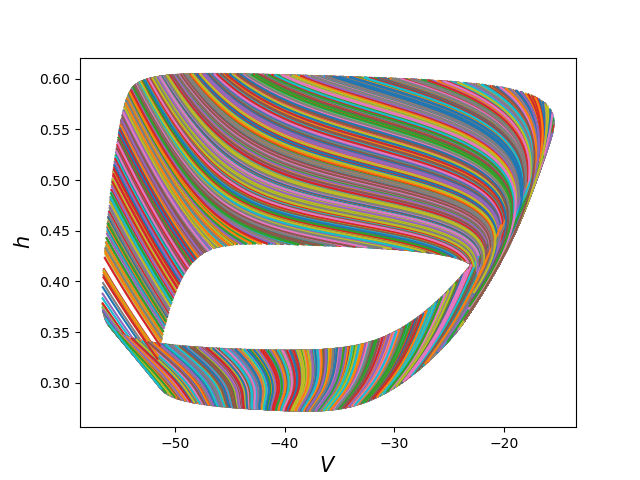

In [15]:
fig, ax = plt.subplots()
ax.plot(combined_data[:, :domain_size].T, combined_data[:, domain_size:].T);
ax.set_xlabel('$V$', fontsize=15);
ax.set_ylabel('$h$', fontsize=15);

if figure_saving:
    fig.savefig(os.path.join(figure_path, 'starting_points.png'), dpi=300)

<IPython.core.display.Javascript object>


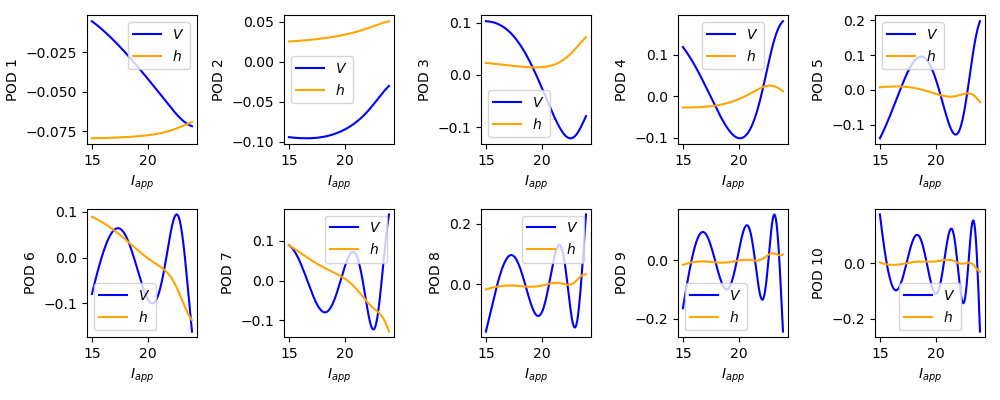

In [16]:
plotted_components = 10
ncols = int(5)
nrows = int(np.ceil(plotted_components / 5))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2 * ncols, 2 * nrows))
component_index = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].plot(domain, pca.components_[component_index, :domain_size], c='blue', label='$V$');
        ax[i, j].plot(domain, pca.components_[component_index, domain_size:], c='orange', label='$h$');
        ax[i, j].set_ylabel('POD ${}$'.format(component_index + 1));
        ax[i, j].set_xlabel('$I_{app}$');
        ax[i, j].legend();
        component_index += 1
fig.tight_layout();

if figure_saving:
    fig.savefig(os.path.join(figure_path, 'POD_modes.png'), dpi=300)

# Look at the Limit Cycle in PCA Space

In [17]:
number_of_retained_pca_coordinates = 8

In [18]:
sim = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain, A=adjacency_matrix)
t_sampling = np.linspace(0, 10, 501)
simulation_result = sim.integrate(X0=X0.T.ravel(), t_span=(t_sampling[0], t_sampling[-1]), t_eval=t_sampling, rtol=1e-5, atol=1e-8)

<IPython.core.display.Javascript object>


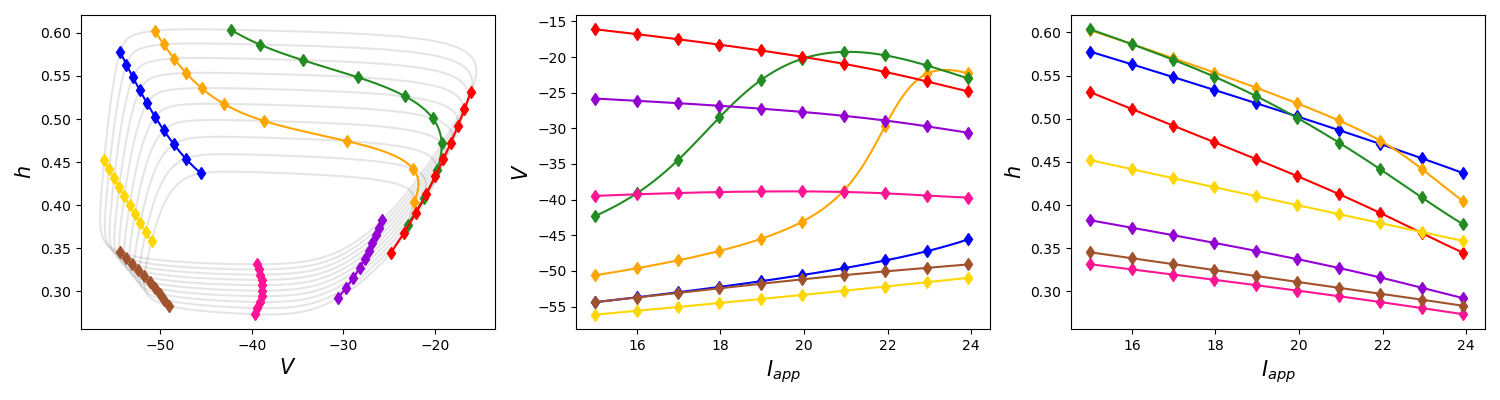

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
colors = ['blue', 'orange', 'forestgreen', 'red', 'darkviolet', 'deeppink', 'sienna', 'gold']

# Fig 1
ax[0].plot(simulation_result.y[:domain_size:14, :395].T, simulation_result.y[domain_size::14, :395].T, c='black', alpha=0.1);
for idx, i in enumerate([0, 40, 52, 70, 120, 180, 200, 270]):
    ax[0].plot(simulation_result.y[:domain_size, i], simulation_result.y[domain_size:, i], c=colors[idx], marker='d', markevery=14);

ax[0].set_xlabel('$V$', fontsize=15);
ax[0].set_ylabel('$h$', fontsize=15);

# Fig 2
for idx, i in enumerate([0, 40, 52, 70, 120, 180, 200, 270]):
    ax[1].plot(domain, simulation_result.y[:domain_size, i], c=colors[idx], marker='d', markevery=14);

ax[1].set_xlabel('$I_{app}$', fontsize=15);
ax[1].set_ylabel('$V$', fontsize=15);

# Fig 3
for idx, i in enumerate([0, 40, 52, 70, 120, 180, 200, 270]):
    ax[2].plot(domain, simulation_result.y[domain_size:, i], c=colors[idx], marker='d', markevery=14);

ax[2].set_xlabel('$I_{app}$', fontsize=15);
ax[2].set_ylabel('$h$', fontsize=15);

fig.tight_layout();
if figure_saving:
    fig.savefig(os.path.join(figure_path, 'demonstration_trajectories_marked.png'), dpi=300)

<IPython.core.display.Javascript object>


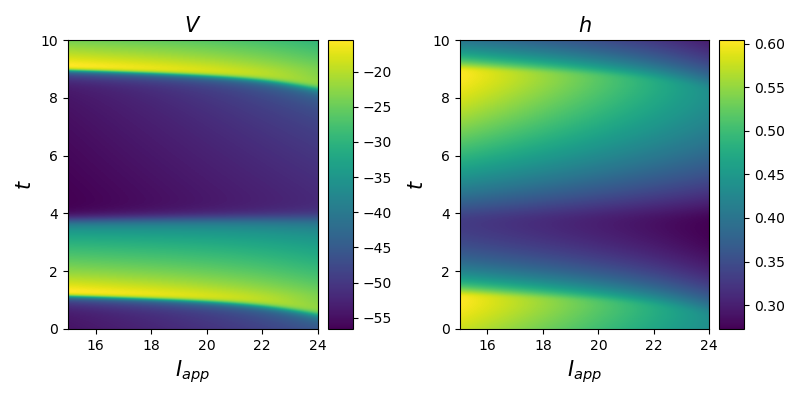

In [20]:
# Limit Cycle in the ambient space.
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

V_vmin, V_vmax = np.min(simulation_result.y[:domain_size, :]), np.max(simulation_result.y[:domain_size, :])
h_vmin, h_vmax = np.min(simulation_result.y[domain_size:, :]), np.max(simulation_result.y[domain_size:, :])

ax1 = ax[0].imshow(simulation_result.y[:domain_size, :].T,
                   extent=[domain[0], domain[-1], t_sampling[0], t_sampling[-1]],
                   aspect='auto',
                   vmin=V_vmin,
                   vmax=V_vmax,
                   origin='lower');

ax2 = ax[1].imshow(simulation_result.y[domain_size:, :].T,
                   extent=[domain[0], domain[-1], t_sampling[0], t_sampling[-1]],
                   aspect='auto',
                   vmin=h_vmin,
                   vmax=h_vmax,
                   origin='lower');

div1 = make_axes_locatable(ax[0])
div2 = make_axes_locatable(ax[1])

cax1 = div1.append_axes('right', size='10%', pad=0.1)
cax2 = div2.append_axes('right', size='10%', pad=0.1)

for i in range(2):
    ax[i].set_xlabel('$I_{app}$', fontsize=15);

ax[0].set_ylabel('$t$', fontsize=15);
ax[1].set_ylabel('$t$', fontsize=15);

ax[0].set_title('$V$', fontsize=15);
ax[1].set_title('$h$', fontsize=15);

fig.colorbar(mappable=ax1, cax=cax1)
fig.colorbar(mappable=ax2, cax=cax2)

# fig.suptitle('Full Ambient Space')
fig.tight_layout();
fig.subplots_adjust(top=0.9)

if figure_saving:
    fig.savefig(os.path.join(figure_path, 'demonstration_spacetime.png'), dpi=300)

<IPython.core.display.Javascript object>


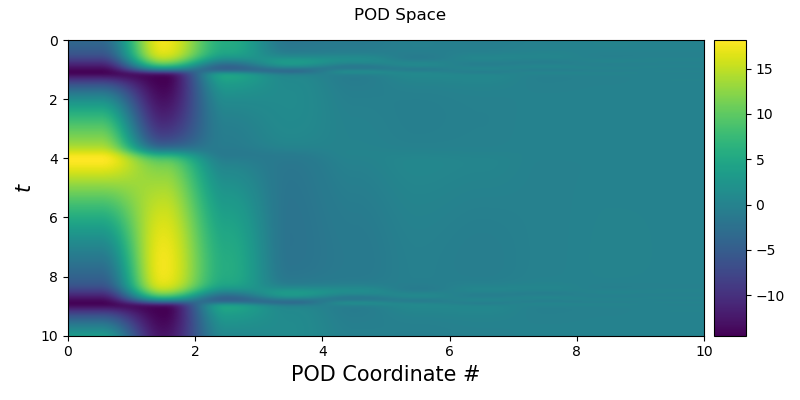

In [21]:
# Limit cycle in the PCA space.
fig, ax = plt.subplots(ncols=1, figsize=(8, 4))

ax1 = ax.imshow(pca.transform(normalizer.normalize(simulation_result.y.T))[:, :10],
                extent=[0, 10, t_sampling[-1], t_sampling[0]], aspect='auto');

div1 = make_axes_locatable(ax)

cax1 = div1.append_axes('right', size='5%', pad=0.1)

ax.set_xlabel('POD Coordinate #', fontsize=15);
ax.set_ylabel('$t$', fontsize=15);

fig.colorbar(mappable=ax1, cax=cax1)

fig.suptitle('POD Space')
fig.tight_layout();
fig.subplots_adjust(top=0.9)

if figure_saving:
    fig.savefig(os.path.join(figure_path, 'POD_demonstration_spacetime.png'), dpi=300)

<IPython.core.display.Javascript object>


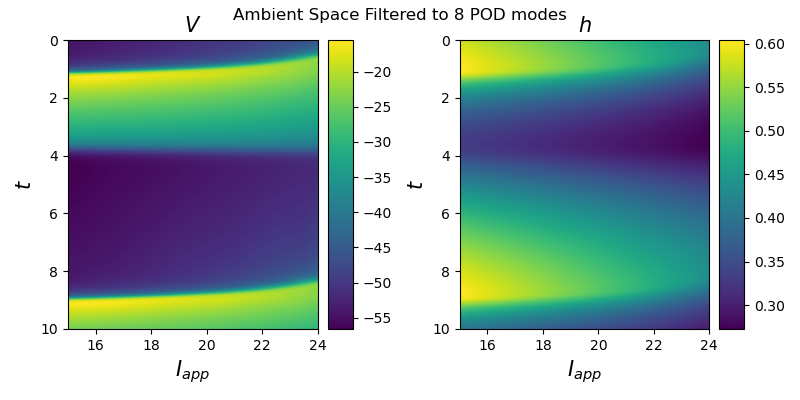

In [22]:
# Limit cycle in the ambient space after filtering to the retained PCA components.
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax1 = ax[0].imshow(pca_filter(simulation_result.y.T, pca, normalizer, number_of_retained_pca_coordinates)[:, :domain_size],
                   extent=[domain[0], domain[-1], t_sampling[-1], t_sampling[0]],
                   aspect='auto',
                   vmin=V_vmin,
                   vmax=V_vmax);
ax2 = ax[1].imshow(pca_filter(simulation_result.y.T, pca, normalizer, number_of_retained_pca_coordinates)[:, domain_size:],
                   extent=[domain[0], domain[-1], t_sampling[-1], t_sampling[0]],
                   aspect='auto',
                   vmin=h_vmin,
                   vmax=h_vmax);

div1 = make_axes_locatable(ax[0])
div2 = make_axes_locatable(ax[1])

cax1 = div1.append_axes('right', size='10%', pad=0.1)
cax2 = div2.append_axes('right', size='10%', pad=0.1)

for i in range(2):
    ax[i].set_xlabel('$I_{app}$', fontsize=15);

ax[0].set_ylabel('$t$', fontsize=15);
ax[1].set_ylabel('$t$', fontsize=15);

ax[0].set_title('$V$', fontsize=15);
ax[1].set_title('$h$', fontsize=15);

fig.colorbar(mappable=ax1, cax=cax1)
fig.colorbar(mappable=ax2, cax=cax2)

fig.suptitle('Ambient Space Filtered to {} POD modes'.format(number_of_retained_pca_coordinates))
fig.tight_layout();
fig.subplots_adjust(top=0.9)

if figure_saving:
    fig.savefig(os.path.join(figure_path, 'filtered_demonstration_spacetime.png'), dpi=300)

# Perturbe in each PCA coordinate

In [23]:
# Retain a limited number of the PCA coordinates.
number_of_retained_pca_coordinates = 8

# Calculate the mean and std of each coordinate for perturbation scaling.
combined_data = np.transpose(starting_points, [0, 2, 1]).reshape((-1, 2 * domain_size))

# Compute the mean and std for each PCA coordinate
combined_mean = np.mean(pca.transform(normalizer.normalize(combined_data)), axis=0)
combined_std = np.std(pca.transform(normalizer.normalize(combined_data)), axis=0)

# Generate some uniform random perturbations over the ranges determined above.
pca_perturbations = np.zeros(combined_data.shape)

# Define the scale of the perturbation for each component.
component_scales = np.zeros(number_of_retained_pca_coordinates)
component_scales[:] = 0.5

for i in range(number_of_retained_pca_coordinates):
    pca_perturbations[:, i] = np.random.uniform(
                                                low=-component_scales[i]*combined_std[i],
                                                high=component_scales[i]*combined_std[i],
                                                size=combined_data.shape[0]
                                               )

# Add the perturbations to the starting points.
pca_starting_points = pca.transform(normalizer.normalize(combined_data))
pca_perturbed_starting_points = pca_starting_points + pca_perturbations
perturbed_starting_points = normalizer.unnormalize(pca.inverse_transform(pca_perturbed_starting_points))
perturbed_starting_points = np.transpose(perturbed_starting_points.reshape((-1, 2, domain_size)), [0, 2, 1])

<IPython.core.display.Javascript object>


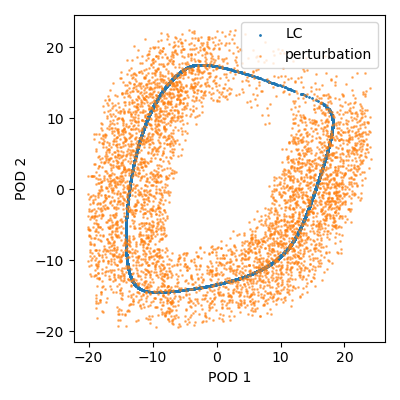

<IPython.core.display.Javascript object>


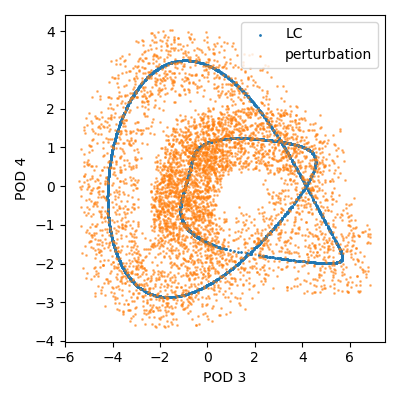

<IPython.core.display.Javascript object>


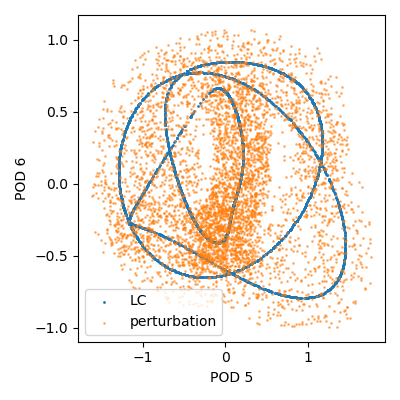

<IPython.core.display.Javascript object>


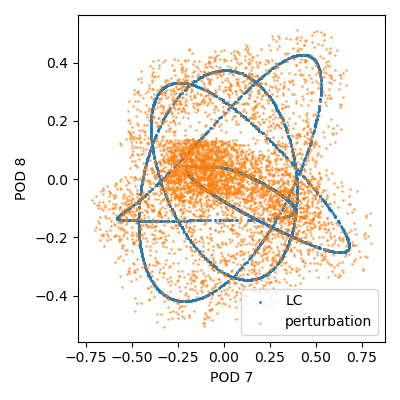

In [24]:
nfigs = int(number_of_retained_pca_coordinates / 2)

for i in range(nfigs):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(pca.transform(normalizer.normalize(combined_data))[:, 2*i], pca.transform(normalizer.normalize(combined_data))[:, 2*i+1], s=1, label='LC');
    ax.scatter(pca_perturbed_starting_points[:, 2*i], pca_perturbed_starting_points[:, 2*i+1], s=1, alpha=0.5, label='perturbation');
    ax.legend();
    ax.set_xlabel('POD {}'.format(2*i+1));
    ax.set_ylabel('POD {}'.format(2*i+2));
    fig.tight_layout();
    
    if figure_saving:
        fig.savefig(os.path.join(figure_path, 'POD_perturbations_{}.png'.format(i+1)), dpi=300)

<IPython.core.display.Javascript object>


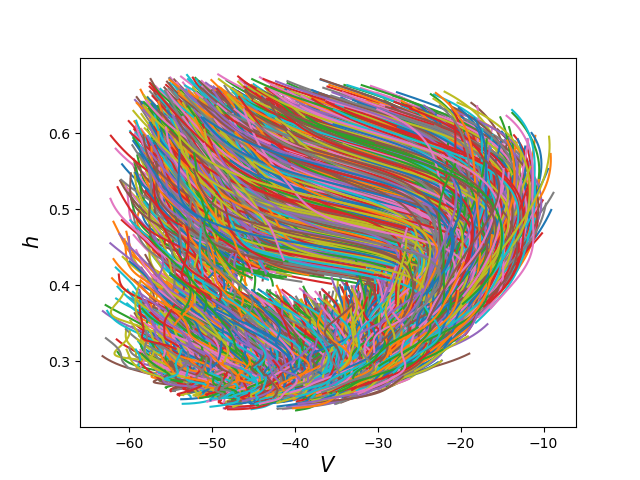

In [25]:
fig, ax = plt.subplots()
ax.plot(perturbed_starting_points[:, :, 0].T, perturbed_starting_points[:, :, 1].T);
ax.set_xlabel('$V$', fontsize=15);
ax.set_ylabel('$h$', fontsize=15);

if figure_saving:
    fig.savefig(os.path.join(figure_path, 'perturbed_starting_points.png'), dpi=300)

# Generate Flow Data and Look at Slope Fields

In [26]:
# Define the data generation parameters.
time_step = 1e-4
flow_time = 5
healing_time = 0
samples_per_trajectory = 500
nsamp = perturbed_starting_points.shape[0] * samples_per_trajectory

X_train, Y_train, results = data_generator(np.transpose(perturbed_starting_points, [0, 2, 1]).reshape((perturbed_starting_points.shape[0], 2 * domain_size)),
                                           flow_time,
                                           healing_time,
                                           time_step,
                                           domain_size,
                                           domain,
                                           samples_per_trajectory
                                          )

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [27]:
# Compute PCA coordinates for the training data.
pca_X_train = np.transpose(X_train, [0, 2, 1]).reshape((nsamp, 2*domain_size))
pca_X_train = pca.transform(normalizer.normalize(pca_X_train))[:, :number_of_retained_pca_coordinates]

pca_Y_train = np.transpose(Y_train, [0, 2, 1]).reshape((nsamp, 2*domain_size))
pca_Y_train = pca.transform(normalizer.normalize(pca_Y_train))[:, :number_of_retained_pca_coordinates]

<IPython.core.display.Javascript object>


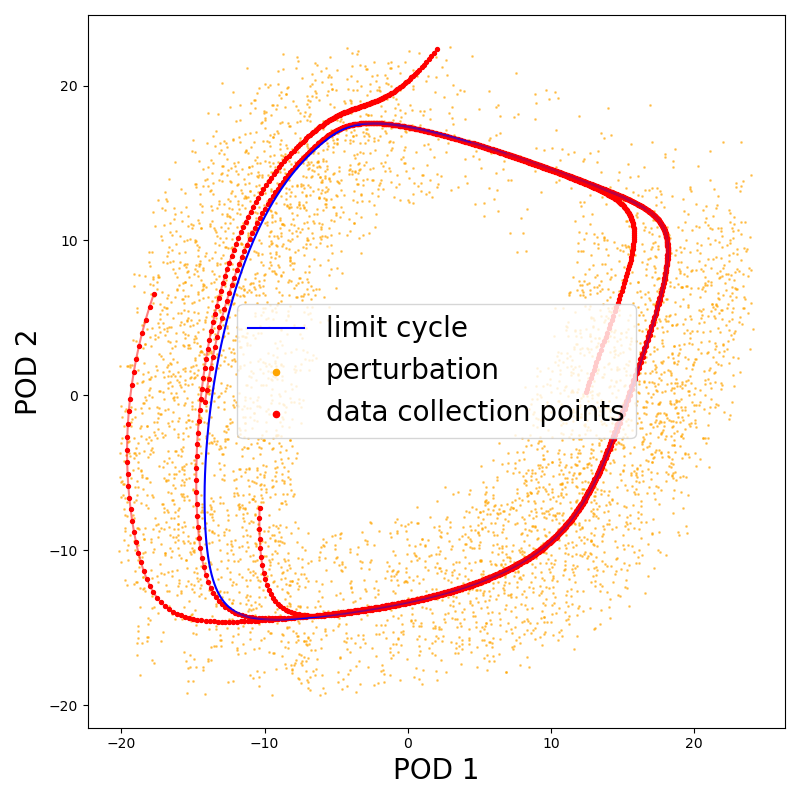

<IPython.core.display.Javascript object>


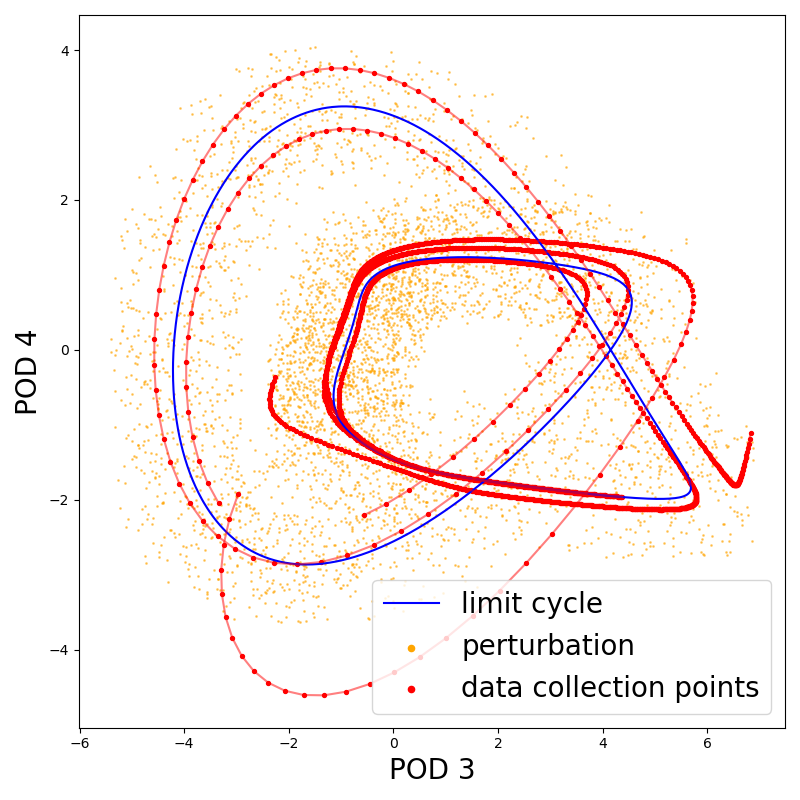

<IPython.core.display.Javascript object>


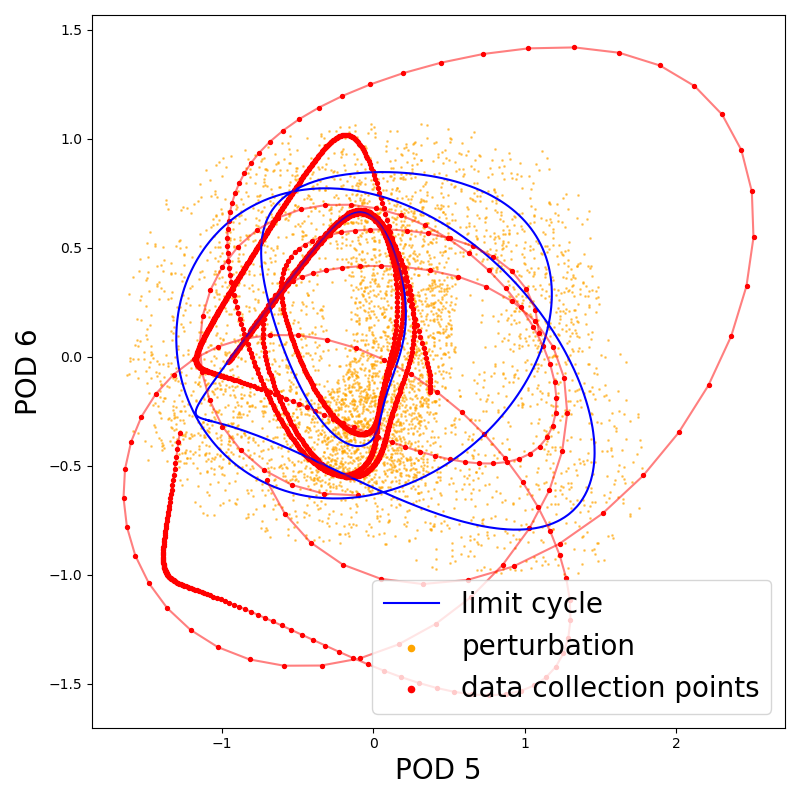

<IPython.core.display.Javascript object>


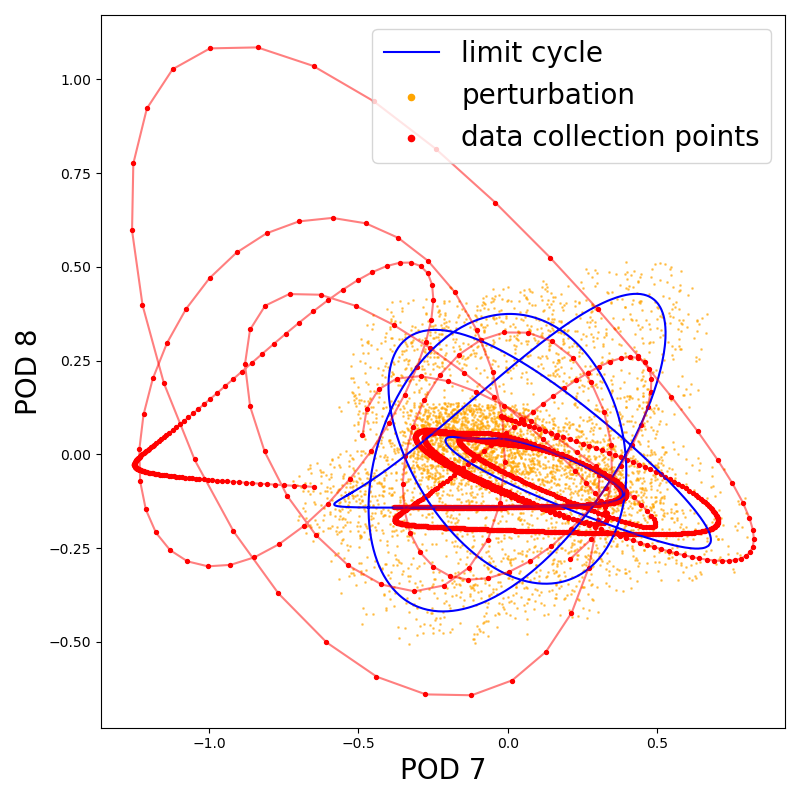

In [28]:
# Check the perturbations of each pca component.
nfigs = int(number_of_retained_pca_coordinates / 2)
number_of_plotted_trajectories = 4
sort_indices = np.argsort(starting_times)

for i in range(nfigs):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(pca.transform(normalizer.normalize(combined_data))[:, 2*i][sort_indices], pca.transform(normalizer.normalize(combined_data))[:, 2*i+1][sort_indices], c='blue', label='limit cycle');
    ax.scatter(pca_perturbed_starting_points[:, 2*i], pca_perturbed_starting_points[:, 2*i+1], s=1, alpha=0.5, c='orange', label='perturbation');
    for j in range(number_of_plotted_trajectories):
        for k in range(samples_per_trajectory):
            ax.scatter(pca_Y_train[samples_per_trajectory*j+k, 2*i], pca_Y_train[samples_per_trajectory*j+k, 2*i+1], c='red', s=8);
        ax.plot(pca_X_train[samples_per_trajectory*j:samples_per_trajectory*(j+1), 2*i].T,
                pca_X_train[samples_per_trajectory*j:samples_per_trajectory*(j+1), 2*i+1].T,
                c='red', alpha=0.5);

    empty_scatter_limit_cycle = matplotlib.lines.Line2D([], [], c='blue')
    empty_scatter_perturbation = ax.scatter(None, None, s=20, c='orange')
    empty_scatter_data_collection = ax.scatter(None, None, s=20, c='red')
    ax.legend([empty_scatter_limit_cycle, empty_scatter_perturbation, empty_scatter_data_collection], ['limit cycle', 'perturbation', 'data collection points'], fontsize=20);
    ax.set_xlabel('POD {}'.format(2*i+1), fontsize=20);
    ax.set_ylabel('POD {}'.format(2*i+2), fontsize=20);

    fig.tight_layout();
    
    if figure_saving:
        fig.savefig(os.path.join(figure_path, 'POD_trajectories_{}.png'.format(i+1)), dpi=300)

# Make a Neural Network Model

In [29]:
# Set parameters for ODE ANN.
nsamp = pca_X_train.shape[0]
validation_split = 0.1
batch_size = int(0.01 * nsamp * (1 - validation_split))

neural_network_parameters = {
                             'n_hidden': 11,
                             'hidden_width': 128,
                             'validation_split': validation_split,
                             'batch_size': batch_size,
                             'epochs': 250,
                             'batch_norm': True
                            }

In [30]:
# Compute the loss weights.
loss_weights = 1 / np.std(pca_X_train, axis=0)

# Set up the layers.
layers = []

for i in range(neural_network_parameters['n_hidden']):
    layers.append(tf.keras.layers.Dense(units=neural_network_parameters['hidden_width'], name='Dense_{}'.format(i)))
    if neural_network_parameters['batch_norm']:
        layers.append(tf.keras.layers.BatchNormalization(name='BN_{}'.format(i)))
    layers.append(tf.keras.layers.ReLU(name='ReLU_{}'.format(i)))
layers.append(tf.keras.layers.Dense(units=number_of_retained_pca_coordinates, name='du_dt_out_layer'))

# Define the derivative model.
inputs = tf.keras.Input(shape=(number_of_retained_pca_coordinates,), name='inputs')

layer_reference = inputs
for layer in layers:
    layer_reference = layer(layer_reference)
derivative_model_output = layer_reference

derivative_model = tf.keras.Model(inputs=inputs, outputs=derivative_model_output, name='derivative_model')
du_dt = derivative_model(inputs)

# Define the flow model.
flow_model_output = ODE_Euler(time_step, name='Euler_step')([inputs, du_dt])

flow_model = tf.keras.Model(inputs=inputs, outputs=flow_model_output, name='flow_model')
flow_model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss=WeightedMeanSquaredError(loss_weights, 1/time_step))
# flow_model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss=tf.keras.losses.MeanSquaredError())

In [31]:
# Define the callbacks.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                                                 monitor='val_loss',
                                                 factor=0.5,
                                                 patience=25,
                                                 min_lr=1e-5,
                                                 cooldown=0,
                                                 min_delta=1e-4
                                                )

# Train

In [32]:
# Train the model
history = flow_model.fit(x={'inputs': pca_X_train},
                         y=pca_Y_train,
                         validation_split=neural_network_parameters['validation_split'],
                         epochs=neural_network_parameters['epochs'],
                         verbose=0,
                         batch_size=neural_network_parameters['batch_size'],
                         callbacks=[Pbar(neural_network_parameters['epochs']), reduce_lr]
                        )

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


<IPython.core.display.Javascript object>


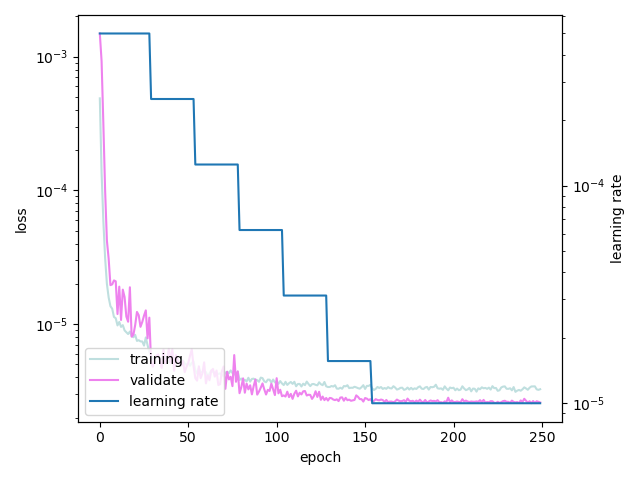

In [33]:
fig, ax = plt.subplots()

line1 = ax.plot(history.epoch, history.history['loss'], c='teal', alpha=0.25, label='training');
if neural_network_parameters['validation_split'] > 0:
    line2 = ax.plot(history.epoch, history.history['val_loss'], c='violet', label='validate');

ax.set_xlabel('epoch');
ax.set_ylabel('loss');
ax.set_yscale('log');

bx = ax.twinx()
line3 = bx.plot(history.epoch, history.history['lr'], label='learning rate');

bx.set_ylabel('learning rate');
bx.set_yscale('log');

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=3);

fig.tight_layout();

# Show that the ODEs were trained

<IPython.core.display.Javascript object>


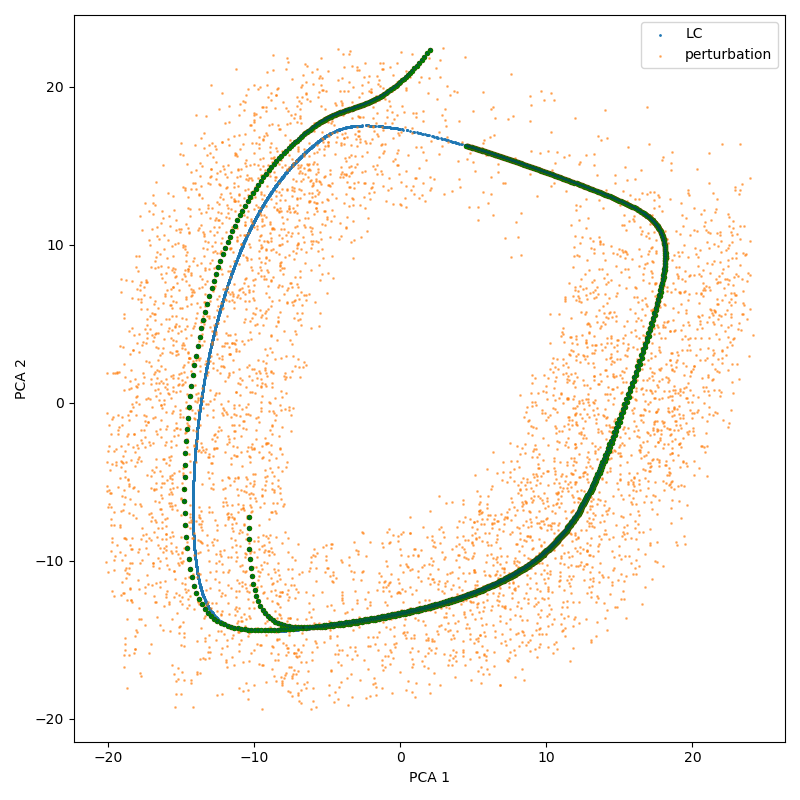

<IPython.core.display.Javascript object>


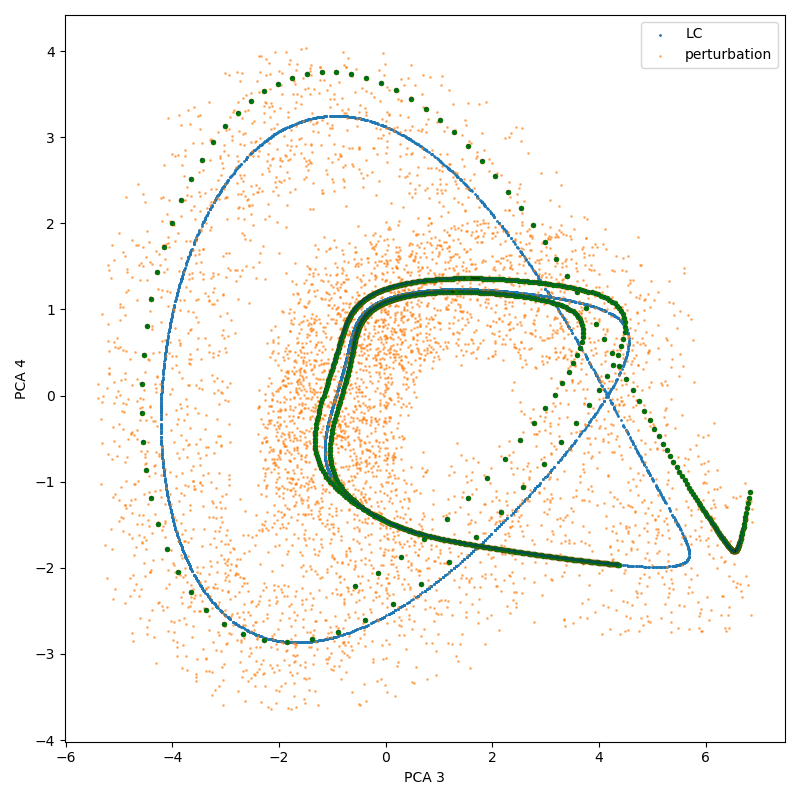

<IPython.core.display.Javascript object>


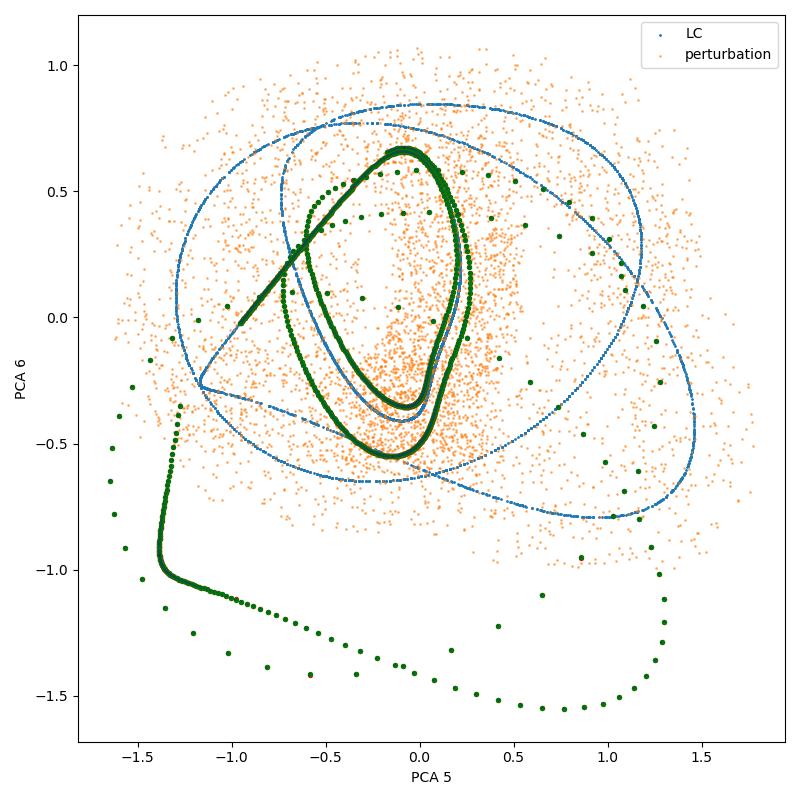

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


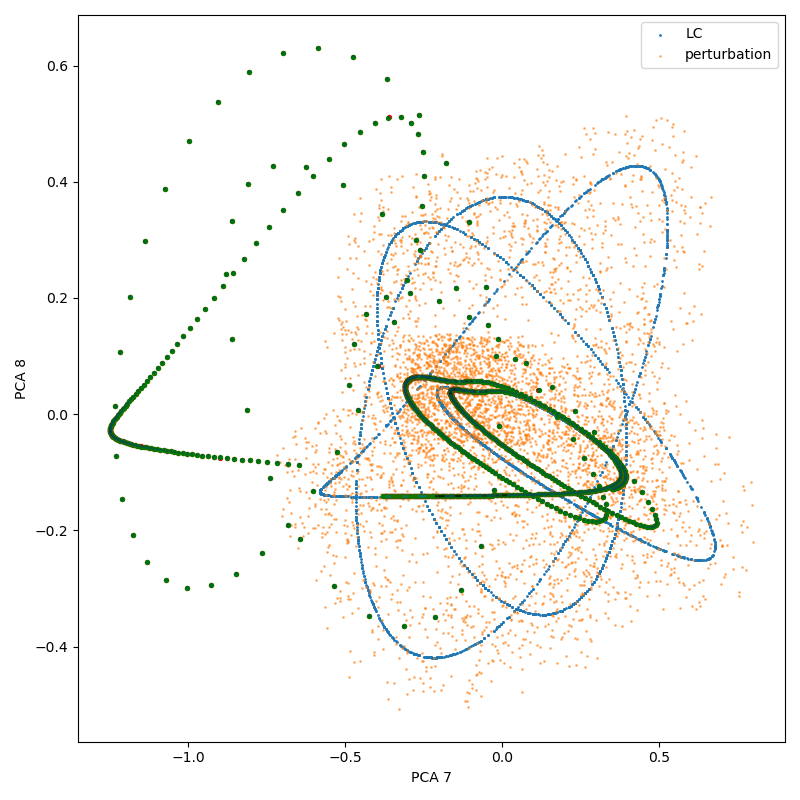

In [34]:
# Check the perturbations of each pca component.
nfigs = int(number_of_retained_pca_coordinates / 2)
predicted_Y = flow_model.predict(x={'inputs': pca_X_train},
                                 batch_size=neural_network_parameters['batch_size'])

for i in range(nfigs):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(pca.transform(normalizer.normalize(combined_data))[:, 2*i], pca.transform(normalizer.normalize(combined_data))[:, 2*i+1], s=1, label='LC');
    ax.scatter(pca_perturbed_starting_points[:, 2*i], pca_perturbed_starting_points[:, 2*i+1], s=1, alpha=0.5, label='perturbation');
    for j in range(1000):
        ax.plot(np.array((pca_X_train[j, 2*i], pca_Y_train[j, 2*i])),
                np.array((pca_X_train[j, 2*i+1], pca_Y_train[j, 2*i+1])),
                c='black', alpha=0.5);
        ax.scatter(pca_Y_train[j, 2*i], pca_Y_train[j, 2*i+1], c='red', s=8);
        ax.plot(np.array((pca_X_train[j, 2*i], predicted_Y[j, 2*i])),
                np.array((pca_X_train[j, 2*i+1], predicted_Y[j, 2*i+1])),
                c='teal', alpha=0.5);
        ax.scatter(predicted_Y[j, 2*i], predicted_Y[j, 2*i+1], c='green', s=8);
        
    ax.legend();
    ax.set_xlabel('PCA {}'.format(2*i+1));
    ax.set_ylabel('PCA {}'.format(2*i+2));

    fig.tight_layout();

In [35]:
sim = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain, A=adjacency_matrix)
t_sampling = np.linspace(0, 30, 30001)
simulation_result = sim.integrate(X0=X0.T.ravel(), t_span=(t_sampling[0], t_sampling[-1]), t_eval=t_sampling, rtol=1e-5, atol=1e-8)

In [36]:
def f(t, x):
    dU_dt = derivative_model.predict_on_batch({'inputs': x[None, :]})
    return dU_dt.ravel()

In [37]:
pca_X0 = pca.transform(normalizer.normalize(X0.T.reshape((1, -1))))[0, :number_of_retained_pca_coordinates]

learned_limit_cycle = solve_ivp(f,
                                (t_sampling[0], t_sampling[-1]),
                                pca_X0,
                                method='RK45',
                                t_eval=t_sampling,
                                rtol=1e-5,
                                atol=1e-8
                               )

<IPython.core.display.Javascript object>


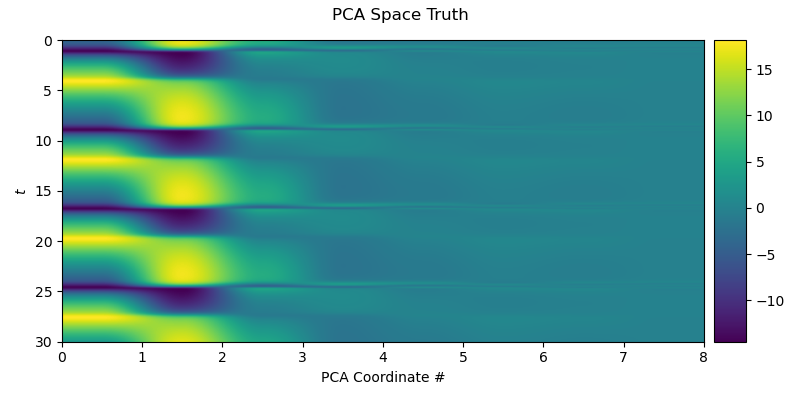

In [38]:
# Limit cycle in the PCA space.
fig, ax = plt.subplots(ncols=1, figsize=(8, 4))

# Get the limits for the colors.
vmin = np.min(pca.transform(normalizer.normalize(simulation_result.y.T))[:, :number_of_retained_pca_coordinates])
vmax = np.max(pca.transform(normalizer.normalize(simulation_result.y.T))[:, :number_of_retained_pca_coordinates])

ax1 = ax.imshow(pca.transform(normalizer.normalize(simulation_result.y.T))[:, :number_of_retained_pca_coordinates],
                extent=[0, number_of_retained_pca_coordinates, t_sampling[-1], t_sampling[0]], aspect='auto',
                vmin=vmin, vmax=vmax);

div1 = make_axes_locatable(ax)

cax1 = div1.append_axes('right', size='5%', pad=0.1)

ax.set_xlabel('PCA Coordinate #');
ax.set_ylabel('$t$');

fig.colorbar(mappable=ax1, cax=cax1)

fig.suptitle('PCA Space Truth')
fig.tight_layout();
fig.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


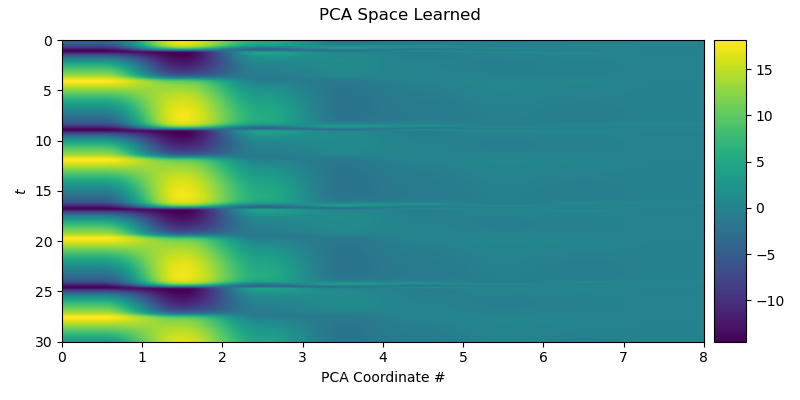

In [39]:
# Limit cycle in the PCA space.
fig, ax = plt.subplots(ncols=1, figsize=(8, 4))

# Use the same values for vmin and vmax defined above.
ax1 = ax.imshow(learned_limit_cycle.y.T,
                extent=[0, number_of_retained_pca_coordinates, t_sampling[-1], t_sampling[0]], aspect='auto',
                vmin=vmin, vmax=vmax);

div1 = make_axes_locatable(ax)

cax1 = div1.append_axes('right', size='5%', pad=0.1)

ax.set_xlabel('PCA Coordinate #');
ax.set_ylabel('$t$');

fig.colorbar(mappable=ax1, cax=cax1)

fig.suptitle('PCA Space Learned')
fig.tight_layout();
fig.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


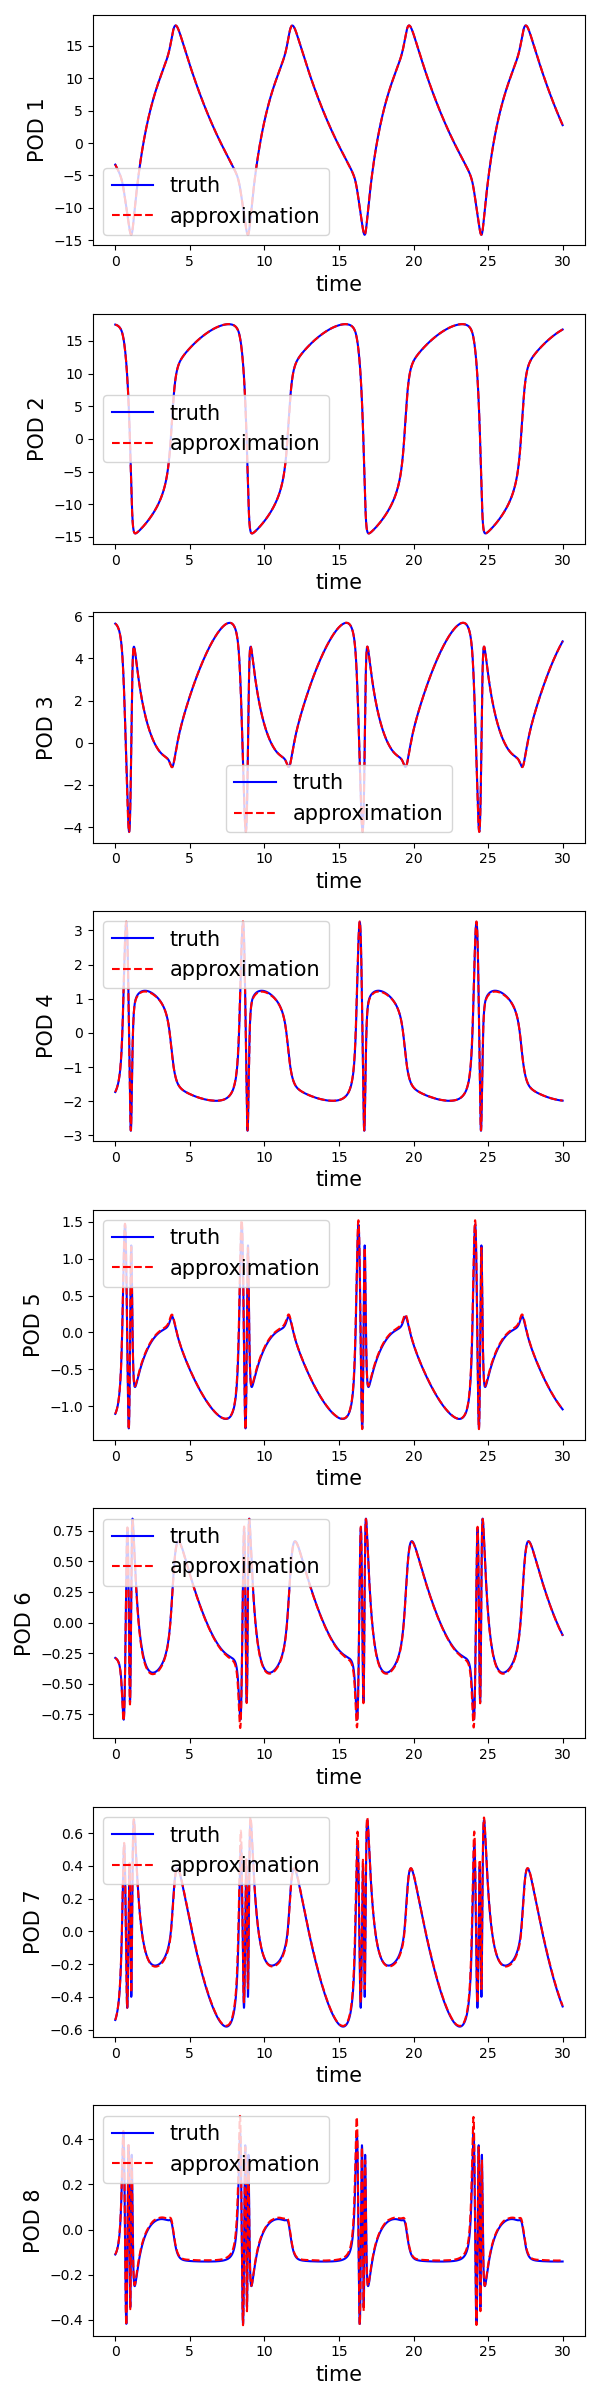

In [40]:
nfigs = number_of_retained_pca_coordinates

true_data = pca.transform(normalizer.normalize(simulation_result.y.T))
learned_data = learned_limit_cycle.y.T

fig, ax = plt.subplots(nrows=nfigs, figsize=(6, 3*nfigs))
for i in range(nfigs):
    ax[i].plot(t_sampling, true_data[:, i], c='blue', label='truth');
    ax[i].plot(t_sampling, learned_data[:, i], linestyle='--', c='red', label='approximation');
    ax[i].set_xlabel('time', fontsize=15);
    ax[i].set_ylabel('POD {}'.format(i+1), fontsize=15)
    ax[i].legend(fontsize=15);
    
fig.tight_layout();

if figure_saving:
    fig.savefig(os.path.join(figure_path, 'POD_timeseries.png'), dpi=300)

<IPython.core.display.Javascript object>


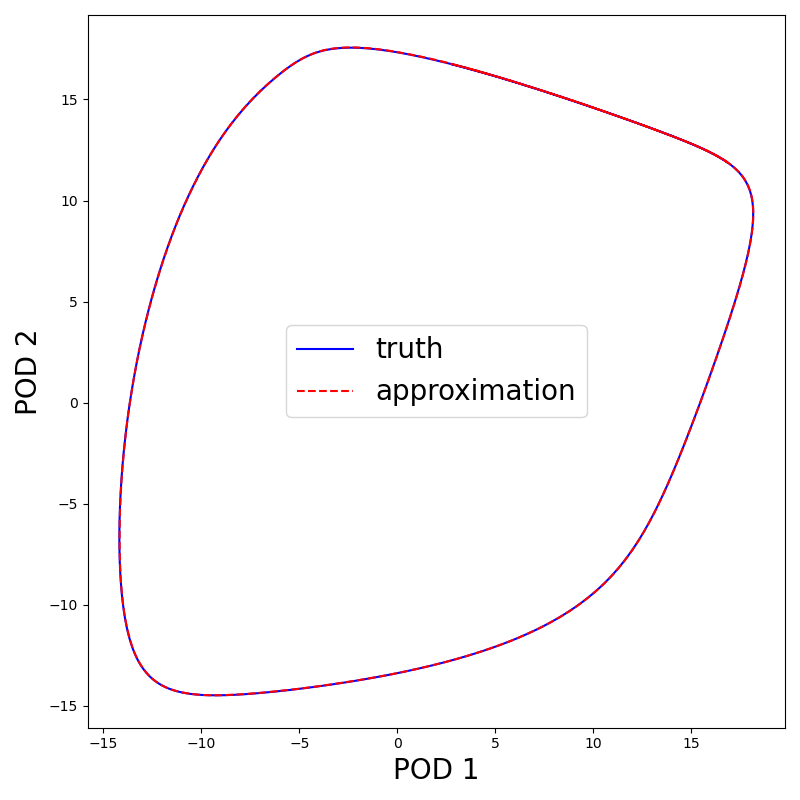

<IPython.core.display.Javascript object>


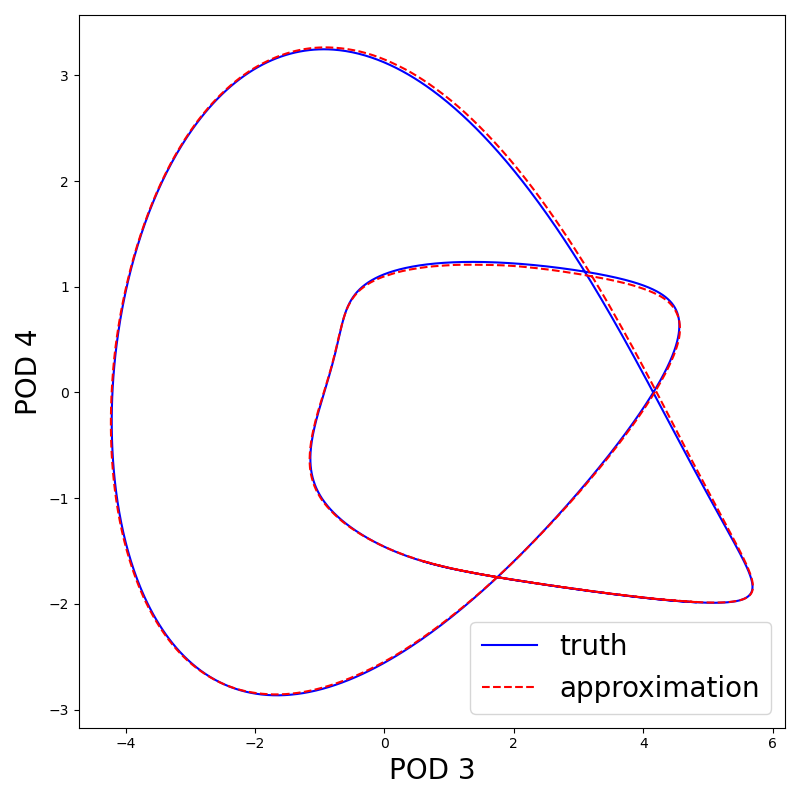

<IPython.core.display.Javascript object>


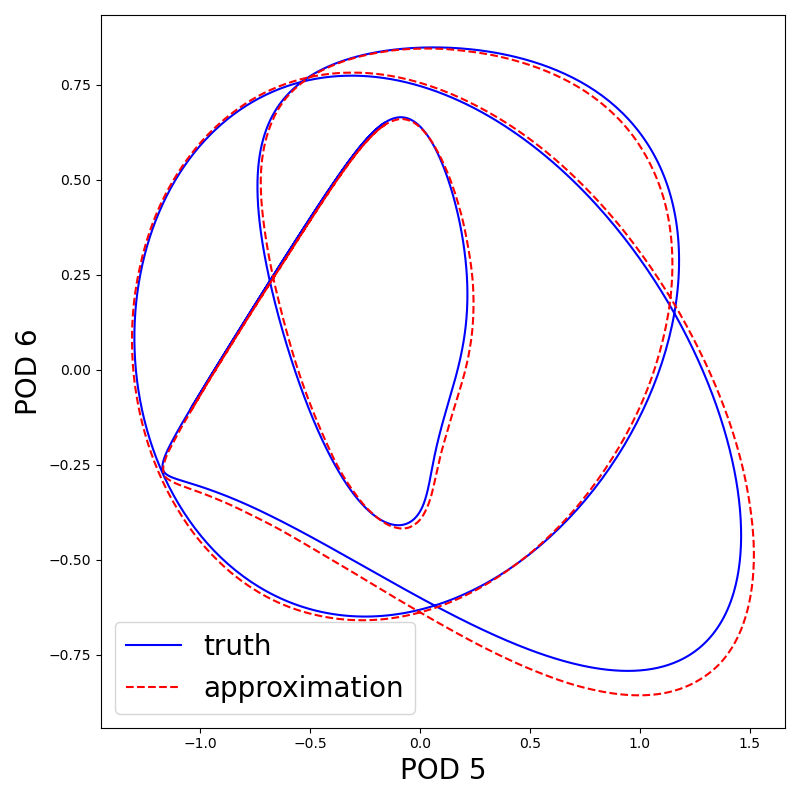

<IPython.core.display.Javascript object>


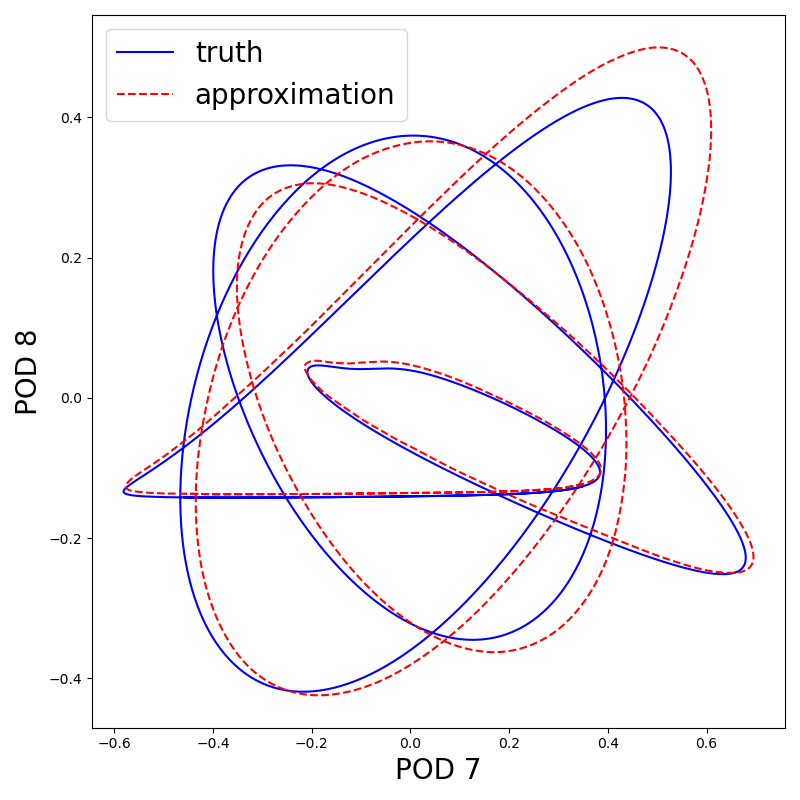

In [41]:
# Check the perturbations of each pca component.
nfigs = int(number_of_retained_pca_coordinates / 2)

for i in range(nfigs):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(true_data[20000:, 2*i], true_data[20000:, 2*i+1], c='blue', label='truth');
    ax.plot(learned_data[20000:, 2*i], learned_data[20000:, 2*i+1], linestyle='--', c='red', label='approximation');

    ax.legend(fontsize=20);
    ax.set_xlabel('POD {}'.format(2*i+1), fontsize=20);
    ax.set_ylabel('POD {}'.format(2*i+2), fontsize=20);

    fig.tight_layout();
    
    if figure_saving:
        fig.savefig(os.path.join(figure_path, 'POD_phase_portrait{}.png'.format(i+1)), dpi=300)

<IPython.core.display.Javascript object>


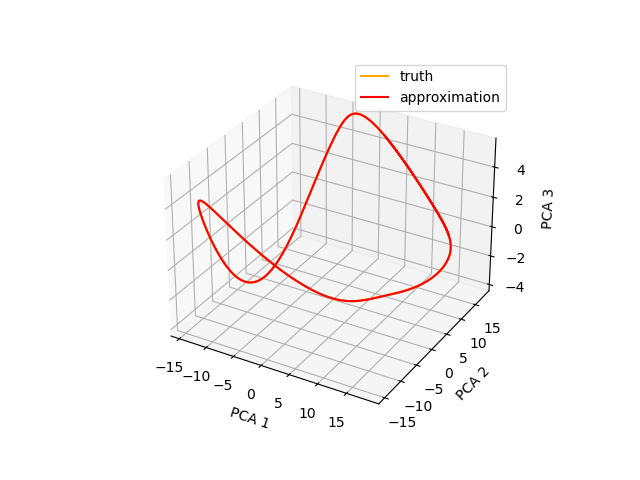

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(true_data[20000:, 0], true_data[20000:, 1], true_data[20000:, 2], c='orange', label='truth');
ax.plot(learned_data[20000:, 0], learned_data[20000:, 1], learned_data[20000:, 2], c='red', label='approximation');
ax.legend();

ax.set_xlabel('PCA {}'.format(1));
ax.set_ylabel('PCA {}'.format(2));
ax.set_zlabel('PCA {}'.format(3));

# Test Additional Points

In [43]:
pca_test_trajectories = []
test_t_sampling = np.linspace(0, 10, 1001)

for point in tqdm.tqdm_notebook(pca_perturbed_starting_points[::50, :number_of_retained_pca_coordinates]):
    pca_test_trajectories.append(
                                 solve_ivp(f,
                                           (test_t_sampling[0], test_t_sampling[-1]),
                                           point,
                                           method='RK45',
                                           t_eval=test_t_sampling,
                                           rtol=1e-5,
                                           atol=1e-8
                                          )
                                )

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


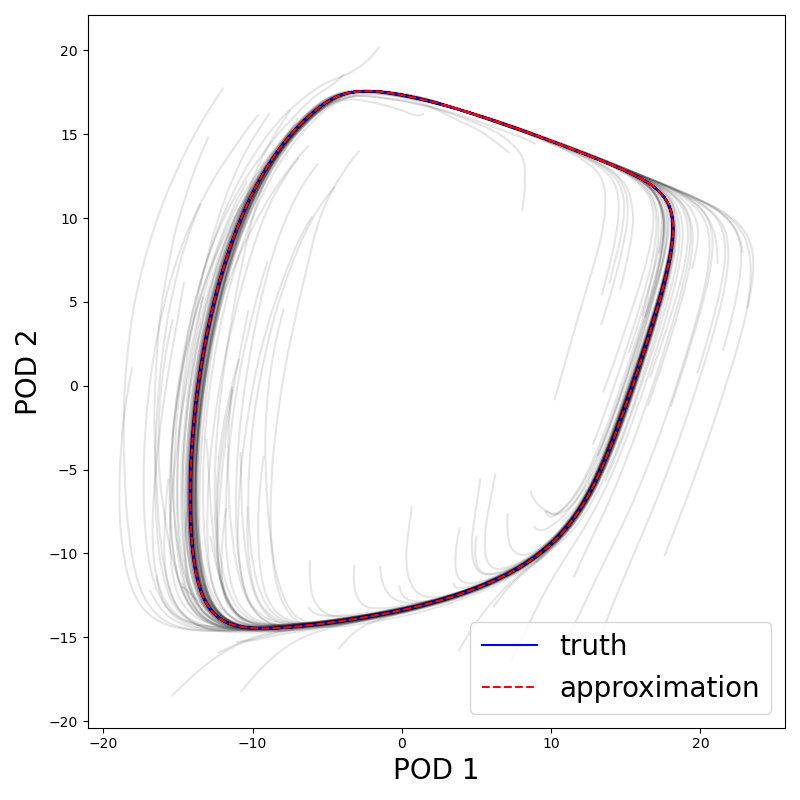

<IPython.core.display.Javascript object>


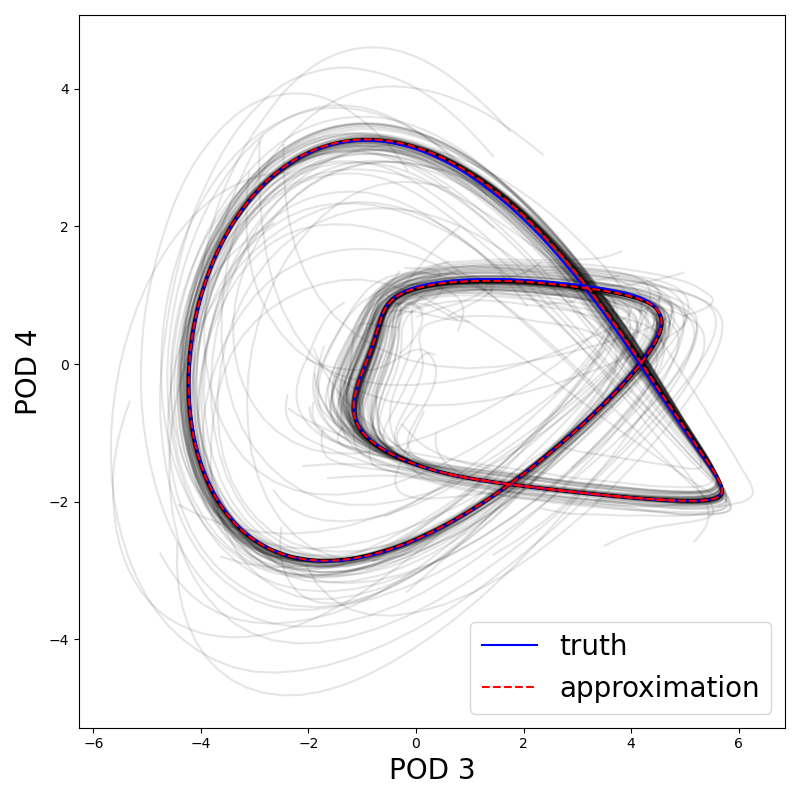

<IPython.core.display.Javascript object>


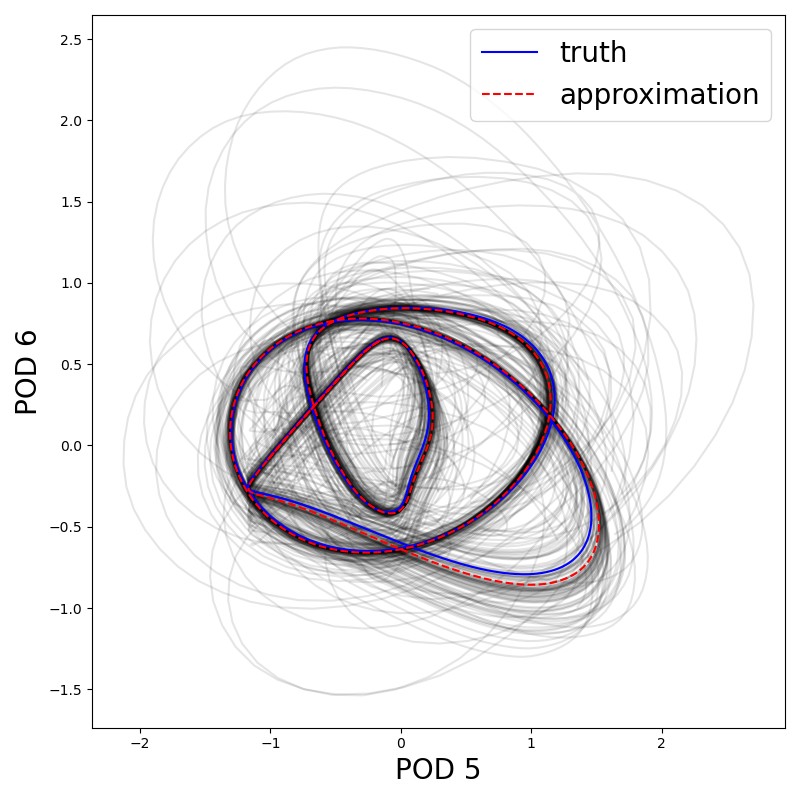

<IPython.core.display.Javascript object>


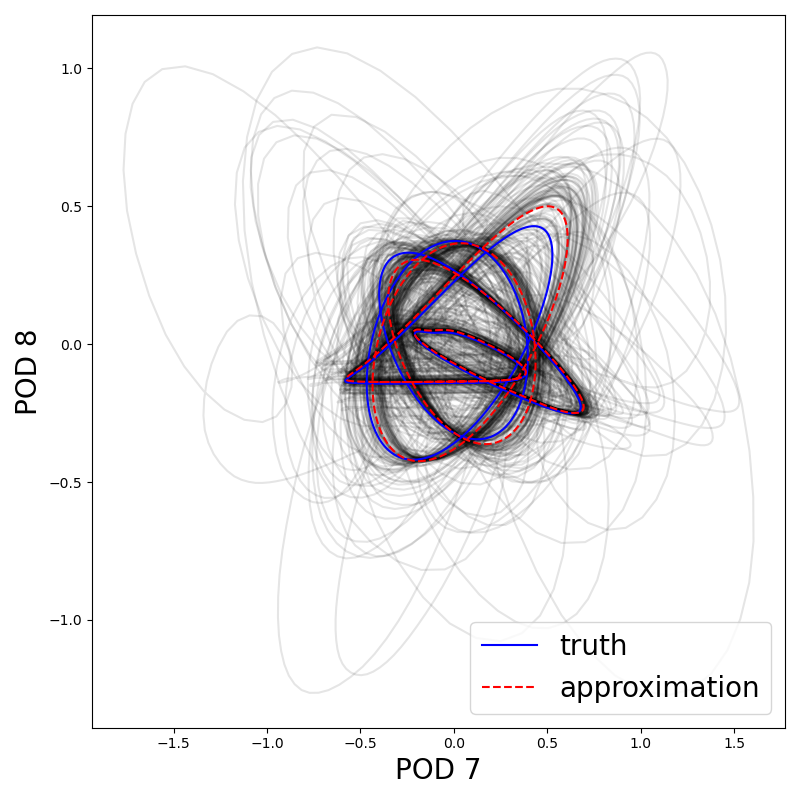

In [44]:
# Check the perturbations of each pca component.
nfigs = int(number_of_retained_pca_coordinates / 2)

for i in range(nfigs):
    fig, ax = plt.subplots(figsize=(8, 8))

    for test_sol in pca_test_trajectories:
        ax.plot(test_sol.y.T[:, 2*i], test_sol.y.T[:, 2*i+1], c='black', alpha=0.1);
    ax.plot(true_data[20000:, 2*i], true_data[20000:, 2*i+1], c='blue', label='truth');
    ax.plot(learned_data[20000:, 2*i], learned_data[20000:, 2*i+1], linestyle='--', c='red', label='approximation');

    ax.legend(fontsize=20);
    ax.set_xlabel('POD {}'.format(2*i+1), fontsize=20);
    ax.set_ylabel('POD {}'.format(2*i+2), fontsize=20);

    fig.tight_layout();
    if figure_saving:
        fig.savefig(os.path.join(figure_path, 'POD_stability_{}.png'.format(i+1)), dpi=300)

# Learn the Higher PCA Modes with a ANN

In [45]:
off_limit_cycle_data = False

if off_limit_cycle_data == True:

    # Define the data generation parameters.
    flow_time = 0.1
    healing_time = 8
    samples_per_trajectory = 10

    pca_mode_train, pca_mode_results = pca_mode_training_data_generator(np.transpose(perturbed_starting_points, [0, 2, 1]).reshape((perturbed_starting_points.shape[0], 2 * domain_size)),
                                                                          flow_time,
                                                                          healing_time,
                                                                          domain_size,
                                                                          domain,
                                                                          samples_per_trajectory
                                                                         )
    
    # Combine the combined data on the limit cycle with the pca_mode_train data around it.
    pca_mode_combined_train = np.concatenate((np.transpose(pca_mode_train, [0, 2, 1]).reshape((-1, 2 * domain_size)), combined_data), axis=0)

else:
    pca_mode_combined_train = combined_data

In [46]:
# Set parameters for PCA Mode ANN.
validation_split = 0.1
nsamp = pca_mode_combined_train.shape[0]
batch_size = int(0.1 * nsamp * (1 - validation_split))

neural_network_parameters = {
                             'n_hidden': 5,
                             'hidden_width': 128,
                             'validation_split': validation_split,
                             'batch_size': batch_size,
                             'epochs': 300,
                             'batch_norm': True
                            }

In [47]:
learned_modes = 4
training_modes = 4

pca_mode_X_train = pca.transform(normalizer.normalize(pca_mode_combined_train))[:, :training_modes]
pca_mode_Y_train = pca.transform(normalizer.normalize(pca_mode_combined_train))[:, training_modes:training_modes+learned_modes]

In [48]:
def pca_reconstruction_model(neural_network_parameters):
    # Set up the layers.
    layers = []

    for i in range(neural_network_parameters['n_hidden']):
        layers.append(tf.keras.layers.Dense(units=neural_network_parameters['hidden_width'], name='Dense_{}'.format(i)))
        if neural_network_parameters['batch_norm']:
            layers.append(tf.keras.layers.BatchNormalization(name='BN_{}'.format(i)))
        layers.append(tf.keras.layers.ReLU(name='ReLU_{}'.format(i)))
    layers.append(tf.keras.layers.Dense(units=1, name='output'))

    # Define the pca mode model.
    inputs = tf.keras.Input(shape=(training_modes,), name='inputs')

    layer_reference = inputs
    for layer in layers:
        layer_reference = layer(layer_reference)
    pca_mode_model_output = layer_reference

    pca_mode_model = tf.keras.Model(inputs=inputs, outputs=pca_mode_model_output, name='pca_mode_model')
    pca_mode_model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss=tf.keras.losses.MeanSquaredError())
    
    return pca_mode_model

In [49]:
# Define the callbacks.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                                                 monitor='val_loss',
                                                 factor=0.5,
                                                 patience=25,
                                                 min_lr=1e-5,
                                                 cooldown=0,
                                                 min_delta=1e-4
                                                )

In [50]:
# Make the models
pca_models = []
for i in range(learned_modes):
    pca_models.append(pca_reconstruction_model(neural_network_parameters))

In [51]:
# Train the models
histories = []
for idx, model in enumerate(pca_models):
    histories.append(
                     model.fit(x={'inputs': pca_mode_X_train},
                               y=pca_mode_Y_train[:, idx],
                               validation_split=neural_network_parameters['validation_split'],
                               epochs=neural_network_parameters['epochs'],
                               verbose=0,
                               batch_size=neural_network_parameters['batch_size'],
                               callbacks=[Pbar(neural_network_parameters['epochs']), reduce_lr]
                              )
                    )

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


<IPython.core.display.Javascript object>


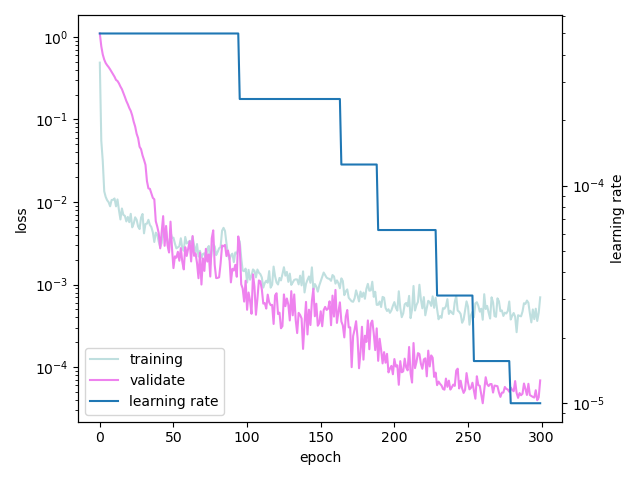

<IPython.core.display.Javascript object>


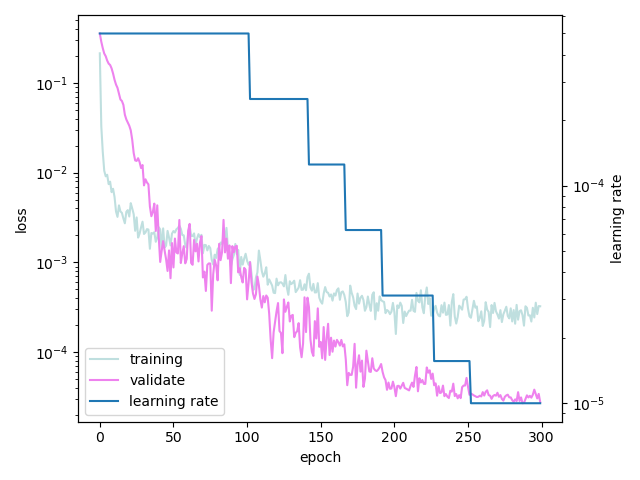

<IPython.core.display.Javascript object>


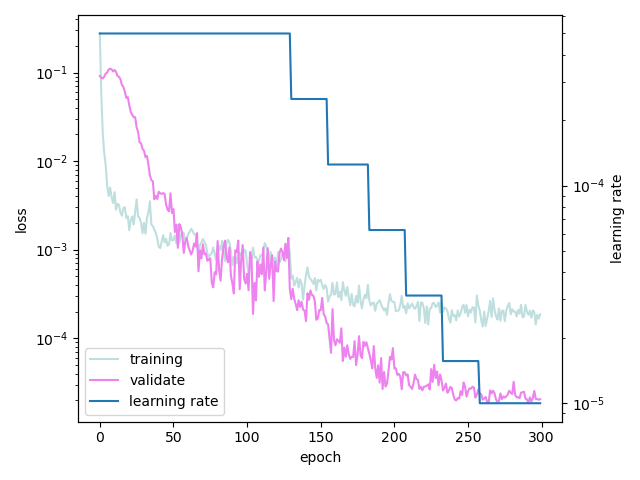

<IPython.core.display.Javascript object>


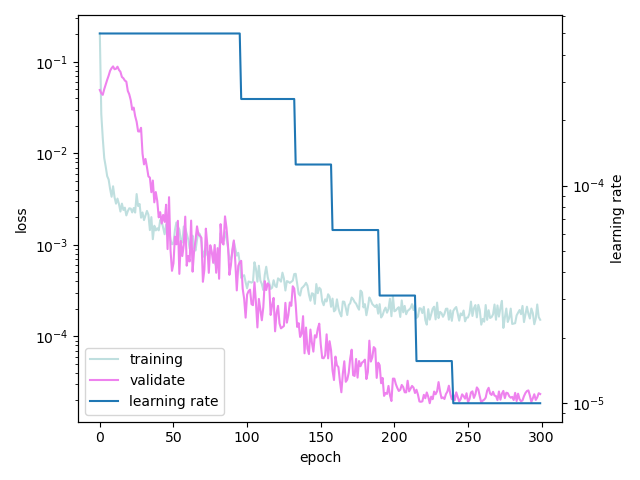

In [52]:
for history in histories:
    fig, ax = plt.subplots()

    line1 = ax.plot(history.epoch, history.history['loss'], c='teal', alpha=0.25, label='training');
    if neural_network_parameters['validation_split'] > 0:
        line2 = ax.plot(history.epoch, history.history['val_loss'], c='violet', label='validate');

    ax.set_xlabel('epoch');
    ax.set_ylabel('loss');
    ax.set_yscale('log');

    bx = ax.twinx()
    line3 = bx.plot(history.epoch, history.history['lr'], label='learning rate');

    bx.set_ylabel('learning rate');
    bx.set_yscale('log');

    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=3);

    fig.tight_layout();

<IPython.core.display.Javascript object>


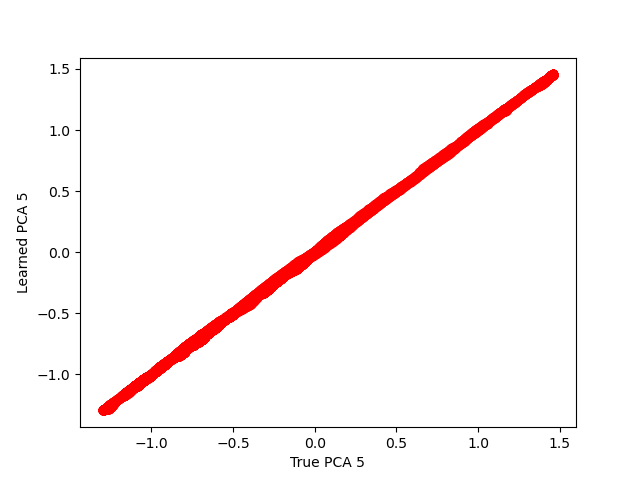

<IPython.core.display.Javascript object>


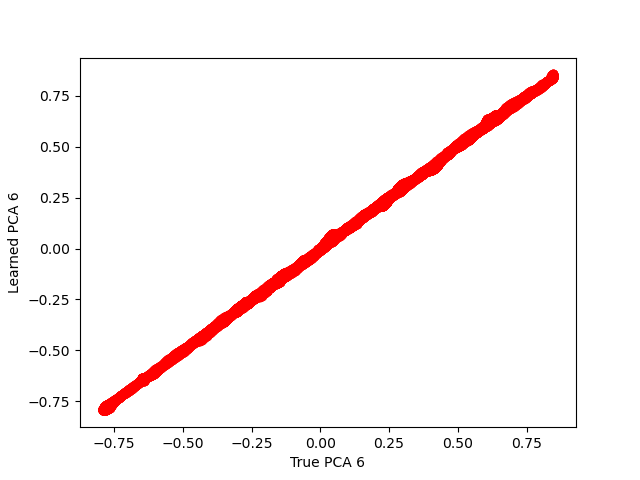

<IPython.core.display.Javascript object>


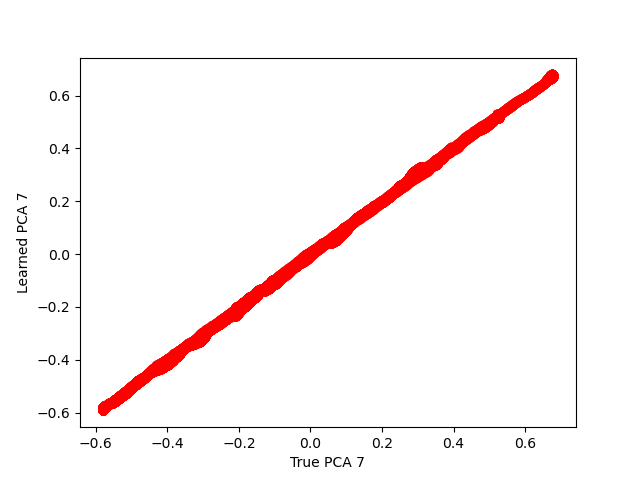

<IPython.core.display.Javascript object>


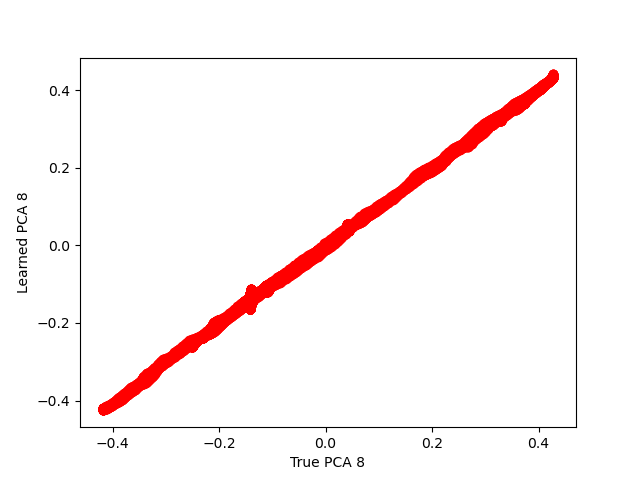

In [53]:
nfigs = learned_modes

true_data = pca.transform(normalizer.normalize(simulation_result.y.T))
learned_data = np.zeros((true_data.shape[0], learned_modes))

for idx, model in enumerate(pca_models):

    learned_data[:, idx] = model.predict(x={'inputs': true_data[:, :training_modes]},
                                         batch_size=neural_network_parameters['batch_size']).squeeze()

for i in range(nfigs):
    fig, ax = plt.subplots()
    ax.scatter(true_data[:, training_modes+i], learned_data[:, i], c='red');
    ax.set_xlabel('True PCA {}'.format(training_modes+i+1));
    ax.set_ylabel('Learned PCA {}'.format(training_modes+i+1))

# Reconstruct the Solution

In [54]:
true_modes = pca.transform(normalizer.normalize(simulation_result.y.T))
reconstructed_modes = np.zeros((true_modes.shape[0], learned_modes))
for idx, model in enumerate(pca_models):
    reconstructed_modes[:, idx] = model.predict(x={'inputs': true_modes[:, :training_modes]},
                                                batch_size=neural_network_parameters['batch_size']).squeeze()

<IPython.core.display.Javascript object>


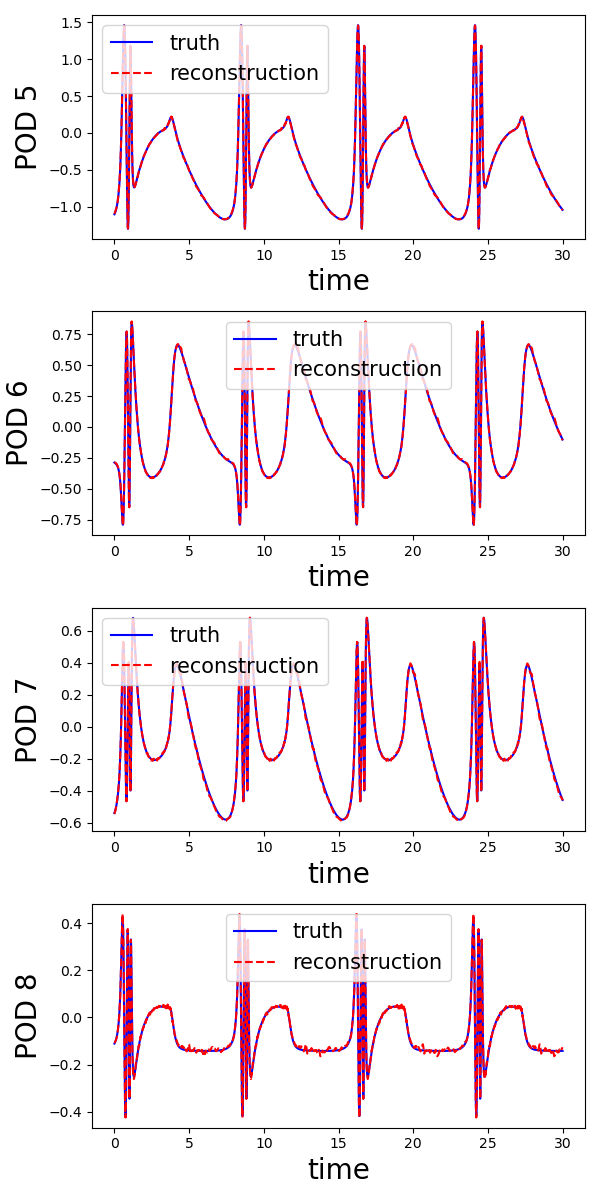

In [55]:
fig, ax = plt.subplots(nrows=learned_modes, figsize=(6, 3*learned_modes))

for i in range(learned_modes):
    ax[i].plot(t_sampling, true_modes[:, i+training_modes], c='blue', label='truth');
    ax[i].plot(t_sampling, reconstructed_modes[:, i], c='red', linestyle='--', label='reconstruction');
    ax[i].set_xlabel('time', fontsize=20);
    ax[i].set_ylabel('POD {}'.format(i+training_modes+1), fontsize=20)
    ax[i].legend(fontsize=15);

fig.tight_layout();
if figure_saving:
    fig.savefig(os.path.join(figure_path, 'POD_reconstruction.png'), dpi=300)

In [56]:
# Test the solution with the learned and reconstructed modes.
reconstructed_solution = np.zeros(simulation_result.y.T.shape)
reconstructed_solution[:, :training_modes+learned_modes] = np.concatenate((learned_limit_cycle.y[:training_modes, :], reconstructed_modes.T), axis=0).T
reconstructed_solution = normalizer.unnormalize(pca.inverse_transform(reconstructed_solution))

<IPython.core.display.Javascript object>


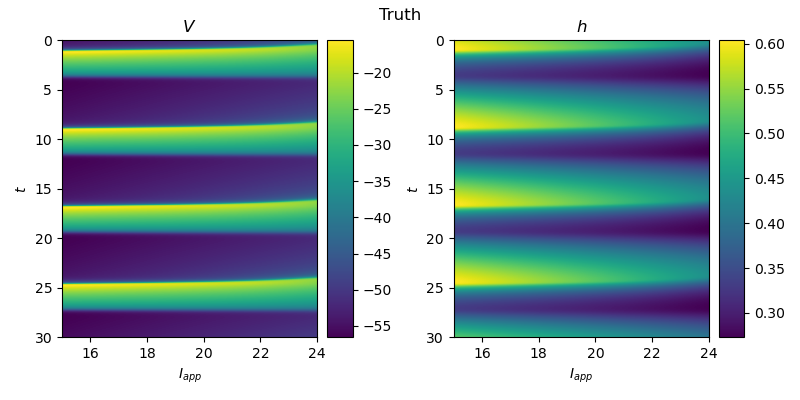

In [57]:
# Limit Cycle in the ambient space.
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

V_vmin, V_vmax = np.min(simulation_result.y[:domain_size, :]), np.max(simulation_result.y[:domain_size, :])
h_vmin, h_vmax = np.min(simulation_result.y[domain_size:, :]), np.max(simulation_result.y[domain_size:, :])

ax1 = ax[0].imshow(simulation_result.y[:domain_size, :].T,
                   extent=[domain[0], domain[-1], t_sampling[-1], t_sampling[0]],
                   aspect='auto',
                   vmin=V_vmin,
                   vmax=V_vmax);

ax2 = ax[1].imshow(simulation_result.y[domain_size:, :].T,
                   extent=[domain[0], domain[-1], t_sampling[-1], t_sampling[0]],
                   aspect='auto',
                   vmin=h_vmin,
                   vmax=h_vmax);

div1 = make_axes_locatable(ax[0])
div2 = make_axes_locatable(ax[1])

cax1 = div1.append_axes('right', size='10%', pad=0.1)
cax2 = div2.append_axes('right', size='10%', pad=0.1)

for i in range(2):
    ax[i].set_xlabel('$I_{app}$');

ax[0].set_ylabel('$t$');
ax[1].set_ylabel('$t$');

ax[0].set_title('$V$');
ax[1].set_title('$h$');

fig.colorbar(mappable=ax1, cax=cax1)
fig.colorbar(mappable=ax2, cax=cax2)

fig.suptitle('Truth')
fig.tight_layout();
fig.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


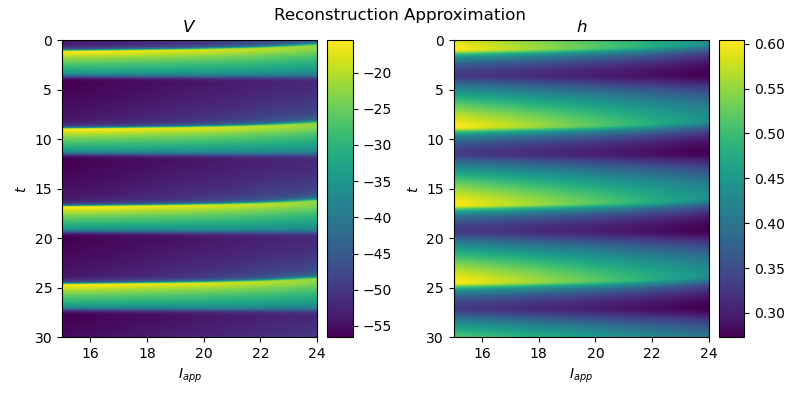

In [58]:
# Limit Cycle in the ambient space.
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

V_vmin, V_vmax = np.min(simulation_result.y[:domain_size, :]), np.max(simulation_result.y[:domain_size, :])
h_vmin, h_vmax = np.min(simulation_result.y[domain_size:, :]), np.max(simulation_result.y[domain_size:, :])

ax1 = ax[0].imshow(reconstructed_solution.T[:domain_size, :].T,
                   extent=[domain[0], domain[-1], t_sampling[-1], t_sampling[0]],
                   aspect='auto',
                   vmin=V_vmin,
                   vmax=V_vmax);

ax2 = ax[1].imshow(reconstructed_solution.T[domain_size:, :].T,
                   extent=[domain[0], domain[-1], t_sampling[-1], t_sampling[0]],
                   aspect='auto',
                   vmin=h_vmin,
                   vmax=h_vmax);

div1 = make_axes_locatable(ax[0])
div2 = make_axes_locatable(ax[1])

cax1 = div1.append_axes('right', size='10%', pad=0.1)
cax2 = div2.append_axes('right', size='10%', pad=0.1)

for i in range(2):
    ax[i].set_xlabel('$I_{app}$');

ax[0].set_ylabel('$t$');
ax[1].set_ylabel('$t$');

ax[0].set_title('$V$');
ax[1].set_title('$h$');

fig.colorbar(mappable=ax1, cax=cax1)
fig.colorbar(mappable=ax2, cax=cax2)

fig.suptitle('Reconstruction Approximation')
fig.tight_layout();
fig.subplots_adjust(top=0.9)